# MSA 2024 Phase 2 - Part 1{-}

The main goal of Part 1 is to load and preprocess the **W Store Sales** dataset and perform preliminary exploratory data analysis (EDA). This will involve cleaning the data, handling missing values, and gaining initial insights into the dataset through visualizations and summary statistics.

## 1. Import libraries and pre-define functions{-}

In [135]:
%matplotlib inline

import sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Optional
import plotly.express as px
from plotly.subplots import make_subplots

def _to_human_readable(text:str):
    '''
    Converts a label into a human readable form
    '''
    return text.replace("_", " ")

def _prepare_labels(df:pd.DataFrame, labels:List[Optional[str]], replace_nones:bool=True):
    '''
    Ensures labels are human readable.
    Automatically picks data if labels not provided explicitly
    '''

    human_readable = {}

    if isinstance(replace_nones, bool):
        replace_nones = [replace_nones] * len(labels)

    for i in range(len(labels)):
        lab = labels[i]
        if replace_nones[i] and (lab is None):
            lab = df.columns[i]
            labels[i] = lab

        # make human-readable
        if lab is not None:
            human_readable[lab] = _to_human_readable(lab)

    return labels, human_readable

def box_and_whisker(df: pd.DataFrame,
                    label_x: Optional[str] = None,
                    label_y: Optional[str] = None,
                    label_x2: Optional[str] = None,
                    title=None,
                    y_axis_range: Optional[list] = None,
                    row: int = 1,
                    col: int = 1,
                    fig=None):
    '''
    Creates a box and whisker plot on the provided fig object.

    df: The data
    label_x: What to group by. Defaults to None
    label_y: What to plot on the y axis. Defaults to count of df.columns[0]
    label_x2: If provided, splits boxplots into 2+ per x value, each with its own colour
    title: Plot title
    y_axis_range: Limits for the y-axis
    row: Row position in subplot
    col: Column position in subplot
    fig: The plotly figure object where the plot will be drawn
    '''

    # Automatically pick columns if not specified
    selected_columns, axis_labels = _prepare_labels(df, [label_x, label_y, label_x2], replace_nones=[False, True, False])

    # Create the box plot
    box_fig = px.box(df,
                     x=selected_columns[0],
                     y=selected_columns[1],
                     color=label_x2,
                     labels=axis_labels,
                     title=title)

    # Update the layout to limit the y-axis if range is specified
    if y_axis_range is not None:
        box_fig.update_layout(yaxis=dict(range=y_axis_range))

    for trace in box_fig.data:
        fig.add_trace(trace, row=row, col=col)

## 2. Find all variables and understand them{-}

### 2.1 Loading data{-}

In [136]:
# read the w store sales dataset
ds_sales = pd.read_csv('./dataset/store_sales.csv', encoding='latin-1')

# preview the first 10 rows of the dataset
ds_sales.head(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
5,24,US-2017-156909,7/16/2017,7/18/2017,Second Class,SF-20065,Sandra Flanagan,Consumer,United States,Philadelphia,...,19140,East,FUR-CH-10002774,Furniture,Chairs,"Global Deluxe Stacking Chair, Gray",71.3720,2,0.30,-1.0196
6,25,CA-2015-106320,9/25/2015,9/30/2015,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,...,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.6300,3,0.00,240.2649
7,28,US-2015-150630,9/17/2015,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.4300,7,0.50,-1665.0522
8,30,US-2015-150630,9/17/2015,9/21/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-FU-10004848,Furniture,Furnishings,"Howard Miller 13-3/4"" Diameter Brushed Chrome ...",124.2000,3,0.20,15.5250
9,37,CA-2016-117590,12/8/2016,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.9200,5,0.60,-147.9630


### 2.2 Exploring the columns{-}

In [137]:
# view the columns in the dataset
ds_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

In [138]:
ds_sales.describe(include='all')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
count,2121.000000,2121,2121,2121,2121,2121,2121,2121,2121,2121,...,2121.000000,2121,2121,2121,2121,2121,2121.000000,2121.000000,2121.000000,2121.000000
unique,NaN,1764,889,960,4,707,707,3,1,371,...,NaN,4,375,1,4,380,NaN,NaN,NaN,NaN
top,NaN,US-2015-129007,9/5/2016,12/6/2017,Standard Class,SV-20365,Seth Vernon,Consumer,United States,New York City,...,NaN,West,FUR-FU-10004270,Furniture,Furnishings,KI Adjustable-Height Table,NaN,NaN,NaN,NaN
freq,NaN,4,10,10,1248,15,15,1113,2121,192,...,NaN,707,16,2121,957,18,NaN,NaN,NaN,NaN
mean,5041.643564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55726.556341,NaN,NaN,NaN,NaN,NaN,349.834887,3.785007,0.173923,8.699327
std,2885.740258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32261.888225,NaN,NaN,NaN,NaN,NaN,503.179145,2.251620,0.181547,136.049246
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1040.000000,NaN,NaN,NaN,NaN,NaN,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22801.000000,NaN,NaN,NaN,NaN,NaN,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60505.000000,NaN,NaN,NaN,NaN,NaN,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,90032.000000,NaN,NaN,NaN,NaN,NaN,435.168000,5.000000,0.300000,33.726600


### 2.3 Remove the redundant columnns{-}
Remove those redundant identifiers and columns which do not help our analysis

In [139]:
# make a copy to keep the original dataset
ds_sales_modified = ds_sales.copy()

# drop the useless identifier columns, category and country columns have only one unique value and ship date is redundant to order date, so we drop them as well, 
columns_to_remove = ['Row ID', 'Customer ID', 'Customer Name', 'Order ID', 'Postal Code', 'Product ID', 'Ship Date', 'Category', 'Country', 'Product Name']
ds_sales_modified.drop(columns=columns_to_remove, inplace=True)

ds_sales_modified.head()

,Order Date,Ship Mode,Segment,City,State,Region,Sub-Category,Sales,Quantity,Discount,Profit
0,11/8/2016,Second Class,Consumer,Henderson,Kentucky,South,Bookcases,261.9600,2,0.00,41.9136
1,11/8/2016,Second Class,Consumer,Henderson,Kentucky,South,Chairs,731.9400,3,0.00,219.5820
2,10/11/2015,Standard Class,Consumer,Fort Lauderdale,Florida,South,Tables,957.5775,5,0.45,-383.0310
3,6/9/2014,Standard Class,Consumer,Los Angeles,California,West,Furnishings,48.8600,7,0.00,14.1694
4,6/9/2014,Standard Class,Consumer,Los Angeles,California,West,Tables,1706.1840,9,0.20,85.3092


### 2.4 Handle date and categorical features{-}
- Date features: convert to date types and extract date elements such as month, day of weeks, quarters, etc  
- Categorical features: encode them

In [140]:
# convert the date columns to datetime
ds_sales_modified['Order Date'] = pd.to_datetime(ds_sales_modified['Order Date'])
ds_sales_modified['Day of Week'] = ds_sales_modified['Order Date'].dt.dayofweek
ds_sales_modified['Year'] = ds_sales_modified['Order Date'].dt.year
ds_sales_modified['Month'] = ds_sales_modified['Order Date'].dt.month
ds_sales_modified['Quarter'] = ds_sales_modified['Order Date'].dt.quarter
ds_sales_modified['Week_begin'] = ds_sales_modified['Order Date'].dt.to_period('W').apply(lambda r: r.start_time)
ds_sales_modified['Month_begin'] = ds_sales_modified['Order Date'].dt.to_period('M').apply(lambda r: r.start_time)
ds_sales_modified['Quarter_begin'] = ds_sales_modified['Order Date'].dt.to_period('Q').apply(lambda r: r.start_time)
ds_sales_modified['Year_begin'] = ds_sales_modified['Order Date'].dt.to_period('Y').apply(lambda r: r.start_time)


# Create a dictionary to store the encoders for each column
encoders = {}

# List of columns to label encode, label encoding can avoid creating too many columns
columns_to_encode = ['Segment','Ship Mode', 'City', 'State', 'Region', 'Sub-Category']

# Label encode each column and store the encoder
for col in columns_to_encode:
    encoder = LabelEncoder()
    ds_sales_modified[col] = encoder.fit_transform(ds_sales[col])
    encoders[col] = encoder

print(ds_sales_modified.info())
# Preview the modified dataset
ds_sales_modified.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order Date     2121 non-null   datetime64[ns]
 1   Ship Mode      2121 non-null   int64         
 2   Segment        2121 non-null   int64         
 3   City           2121 non-null   int64         
 4   State          2121 non-null   int64         
 5   Region         2121 non-null   int64         
 6   Sub-Category   2121 non-null   int64         
 7   Sales          2121 non-null   float64       
 8   Quantity       2121 non-null   int64         
 9   Discount       2121 non-null   float64       
 10  Profit         2121 non-null   float64       
 11  Day of Week    2121 non-null   int32         
 12  Year           2121 non-null   int32         
 13  Month          2121 non-null   int32         
 14  Quarter        2121 non-null   int32         
 15  Week_begin     2121 n

,Order Date,Ship Mode,Segment,City,State,Region,Sub-Category,Sales,Quantity,Discount,Profit,Day of Week,Year,Month,Quarter,Week_begin,Month_begin,Quarter_begin,Year_begin
0,2016-11-08,2,0,137,15,2,0,261.9600,2,0.00,41.9136,1,2016,11,4,2016-11-07,2016-11-01,2016-10-01,2016-01-01
1,2016-11-08,2,0,137,15,2,1,731.9400,3,0.00,219.5820,1,2016,11,4,2016-11-07,2016-11-01,2016-10-01,2016-01-01
2,2015-10-11,3,0,108,8,2,3,957.5775,5,0.45,-383.0310,6,2015,10,4,2015-10-05,2015-10-01,2015-10-01,2015-01-01
3,2014-06-09,3,0,184,3,3,2,48.8600,7,0.00,14.1694,0,2014,6,2,2014-06-09,2014-06-01,2014-04-01,2014-01-01
4,2014-06-09,3,0,184,3,3,3,1706.1840,9,0.20,85.3092,0,2014,6,2,2014-06-09,2014-06-01,2014-04-01,2014-01-01


## 3. Clean data{-}

### 3.1 check any for null values{-}

In [141]:
ds_sales_modified.isnull().sum()

Order Date       0
Ship Mode        0
Segment          0
City             0
State            0
Region           0
Sub-Category     0
Sales            0
Quantity         0
Discount         0
Profit           0
Day of Week      0
Year             0
Month            0
Quarter          0
Week_begin       0
Month_begin      0
Quarter_begin    0
Year_begin       0
dtype: int64

### 3.2 check for any NA values{-}

In [142]:
ds_sales_modified.isna().sum()

Order Date       0
Ship Mode        0
Segment          0
City             0
State            0
Region           0
Sub-Category     0
Sales            0
Quantity         0
Discount         0
Profit           0
Day of Week      0
Year             0
Month            0
Quarter          0
Week_begin       0
Month_begin      0
Quarter_begin    0
Year_begin       0
dtype: int64

## 4. Visualise data and get some prelimary insights{-}

### 4.1 Distribution of all features{-}

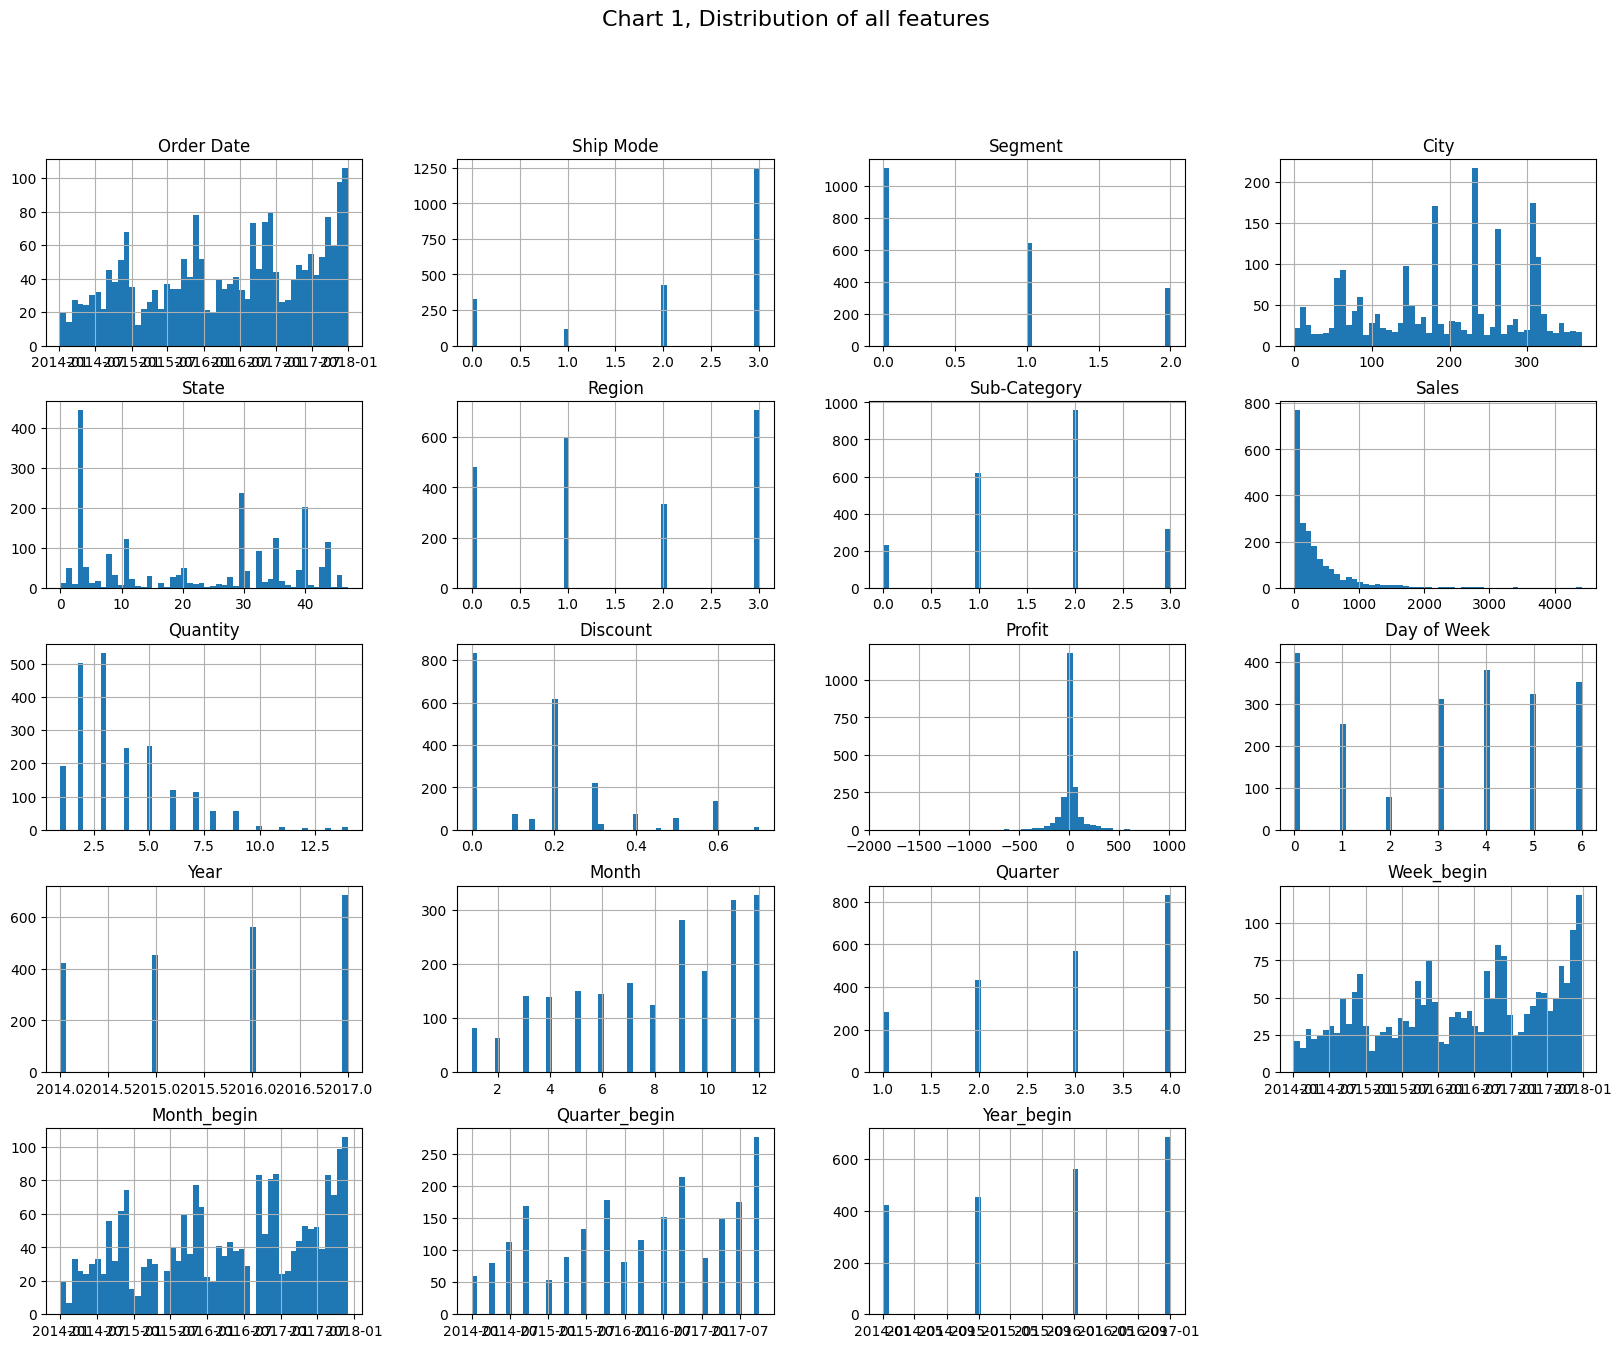

In [143]:
fig = ds_sales_modified.hist(bins=50, figsize=(20, 15))

plt.suptitle('Chart 1, Distribution of all features', fontsize=16)
plt.show()

The date related features indicate an increasing trend and season patterns. And city and state distributions highlight regional sales concentrations, with certain areas contributing more significantly. 

### 4.2 Top sales by categorical features{-}

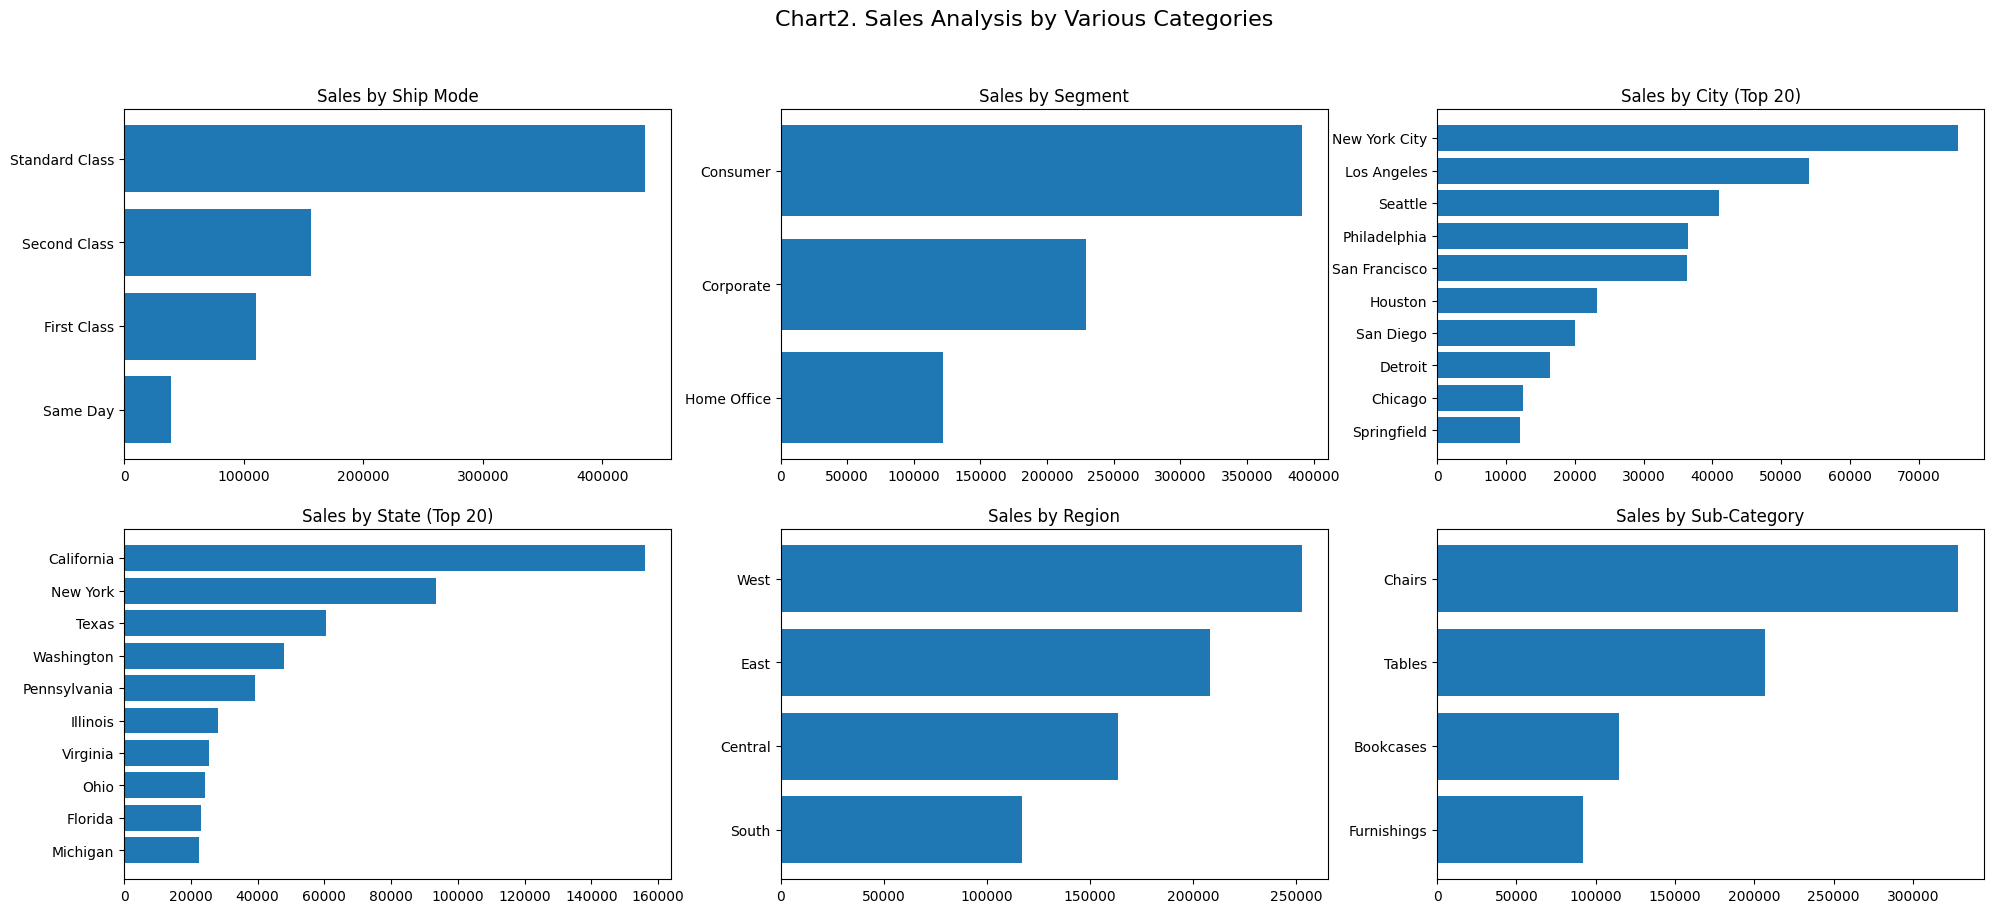

In [144]:
ship_mode_data = ds_sales.groupby('Ship Mode')['Sales'].sum().sort_values(ascending=True)
segment_data = ds_sales.groupby('Segment')['Sales'].sum().sort_values(ascending=True)
city_data = ds_sales.groupby('City')['Sales'].sum().sort_values(ascending=True).tail(10)
state_data = ds_sales.groupby('State')['Sales'].sum().sort_values(ascending=True).tail(10)
region_data = ds_sales.groupby('Region')['Sales'].sum().sort_values(ascending=True)
subcategory_data = ds_sales.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=True)

fig, axs = plt.subplots(2, 3, figsize=(24, 10))

fig.suptitle('Chart2. Sales Analysis by Various Categories', fontsize=16)

axs[0, 0].barh(ship_mode_data.index, ship_mode_data.values)
axs[0, 0].set_title('Sales by Ship Mode')

axs[0, 1].barh(segment_data.index, segment_data.values)
axs[0, 1].set_title('Sales by Segment')

axs[0, 2].barh(city_data.index, city_data.values)
axs[0, 2].set_title('Sales by City (Top 20)')

axs[1, 0].barh(state_data.index, state_data.values)
axs[1, 0].set_title('Sales by State (Top 20)')

axs[1, 1].barh(region_data.index, region_data.values)
axs[1, 1].set_title('Sales by Region')

axs[1, 2].barh(subcategory_data.index, subcategory_data.values)
axs[1, 2].set_title('Sales by Sub-Category')

plt.show()


Standard Class is the most common shipping method, and the Consumer segment leads in sales. New York City, Los Angeles, and Seattle are the top cities, while California, New York, and Texas are the top states. The West region outperforms other regions in sales. Among product sub-categories, Chairs generate the highest sales, followed by Tables and Bookcases.

### 4.3 Plot pair scatter charts and box charts {-}

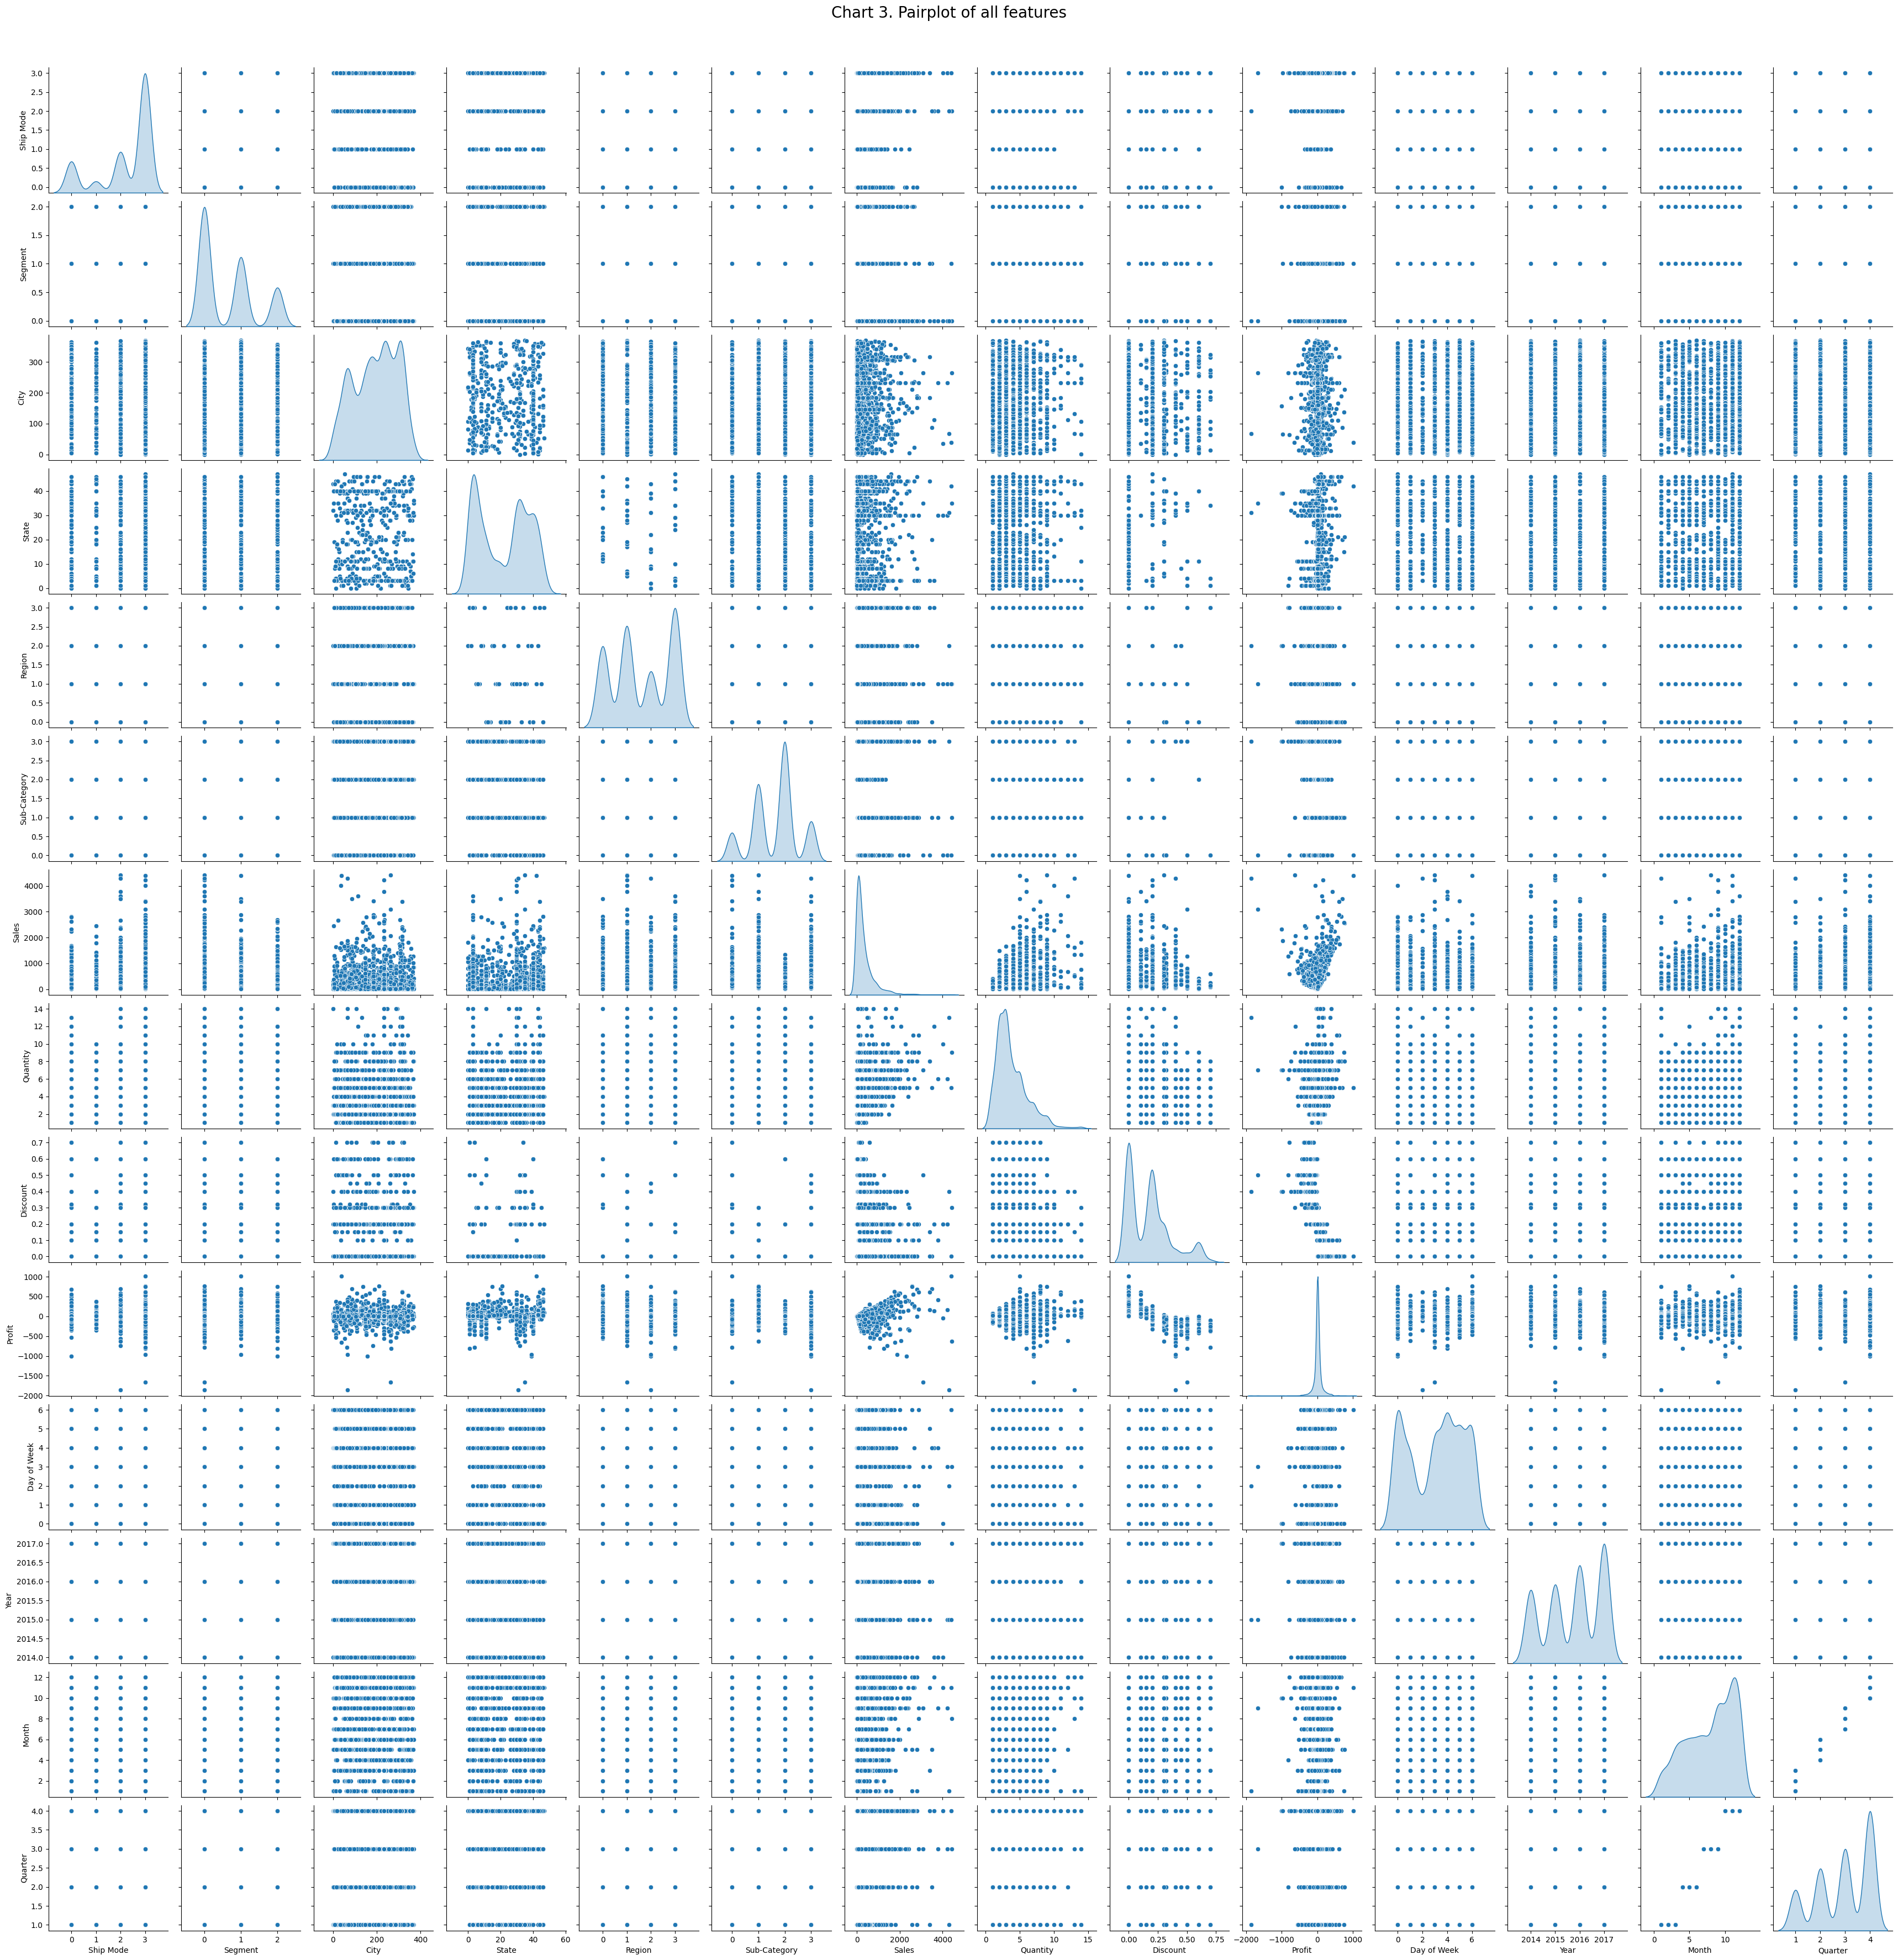

In [145]:
pairplot = sns.pairplot(ds_sales_modified, diag_kind='kde')
pairplot.fig.suptitle('Chart 3. Pairplot of all features', y=1.02, fontsize=20)

plt.show()

In [146]:
# Example usage
fig = make_subplots(rows=3, cols=3, subplot_titles=("Sales by Segment", "Sales by Ship Mode", "Sales by Region", "Sales by State", "Sales by City", "Sales by Sub-Category", "Sales by Quantity", "Sales by Discount"))

box_and_whisker(ds_sales_modified, label_x='Segment', label_y='Sales', title='Sales by Segment', y_axis_range=[0, 1000], row=1, col=1, fig=fig)
box_and_whisker(ds_sales_modified, label_x='Ship Mode', label_y='Sales', title='Sales by Ship Mode', y_axis_range=[0, 1000], row=1, col=2, fig=fig)
box_and_whisker(ds_sales_modified, label_x='Region', label_y='Sales', title='Sales by Region', y_axis_range=[0, 1000], row=1, col=3, fig=fig)
box_and_whisker(ds_sales_modified, label_x='State', label_y='Sales', title='Sales by State', y_axis_range=[0, 1000], row=2, col=1, fig=fig)
box_and_whisker(ds_sales_modified, label_x='City', label_y='Sales', title='Sales by City', y_axis_range=[0, 1000], row=2, col=2, fig=fig)
box_and_whisker(ds_sales_modified, label_x='Sub-Category', label_y='Sales', title='Sales by Sub-Category', y_axis_range=[0, 1000], row=2, col=3, fig=fig)
box_and_whisker(ds_sales_modified, label_x='Quantity', label_y='Sales', title='Sales by Quantity', y_axis_range=[0, 1000], row=3, col=1, fig=fig)
box_and_whisker(ds_sales_modified, label_x='Discount', label_y='Sales', title='Sales by Discount', y_axis_range=[0, 1000], row=3, col=2, fig=fig)

fig.update_layout(height=800, width=1200, title_text="Chart 4. Sales Analysis by Various Categories")

fig.show()




In [147]:
# Get the original label for Sub-Category with encoded value 2
original_label = encoders['Sub-Category'].inverse_transform([2])[0]
print(f"The original label for Sub-Category with encoded value 2 is: {original_label}")


The original label for Sub-Category with encoded value 2 is: Furnishings


Except the date patterns we've already found, from the box plots above we observed there's a sub-cateogry['2']->'Furnishing', which has relative low sales.

### 4.4 Exploring time-series{-}

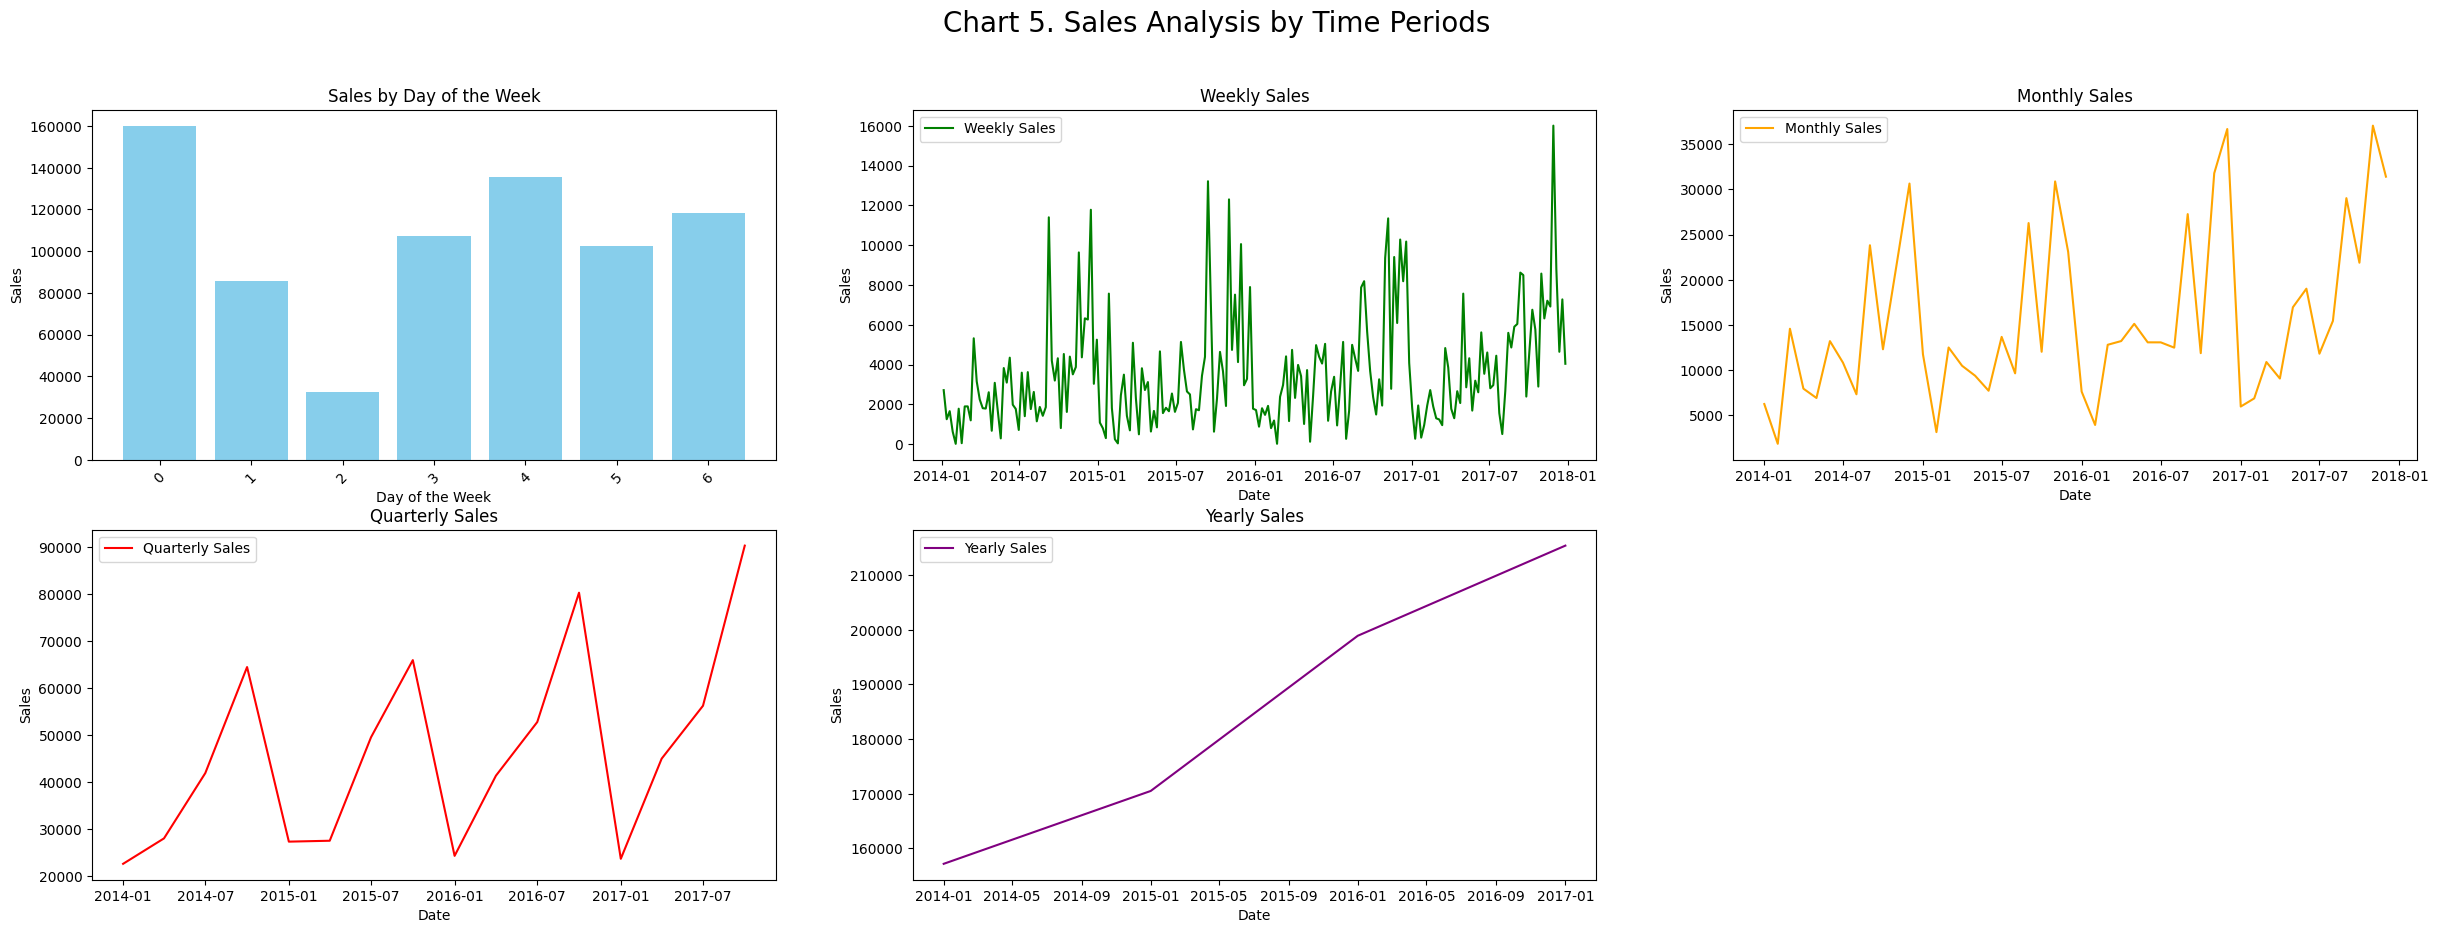

In [148]:
# Aggregate Sales data by day of the week
weekly_sales_by_day = ds_sales_modified.groupby('Day of Week')['Sales'].sum()

# Aggregate Sales data by week
weekly_sales = ds_sales_modified.groupby('Week_begin')['Sales'].sum()

# Aggregate Sales data by month
monthly_sales = ds_sales_modified.groupby('Month_begin')['Sales'].sum()

# Aggregate Sales data by quarter
quarterly_sales = ds_sales_modified.groupby('Quarter_begin')['Sales'].sum()

# Aggregate Sales data by year
yearly_sales = ds_sales_modified.groupby('Year_begin')['Sales'].sum()


# Create a 2x3 grid of subplots with each subplot having a figsize of 10x5
fig, axs = plt.subplots(2, 3, figsize=(30, 10))

# Plot weekly sales by day of the week
axs[0, 0].bar(weekly_sales_by_day.index, weekly_sales_by_day, color='skyblue')
axs[0, 0].set_xlabel('Day of the Week')
axs[0, 0].set_ylabel('Sales')
axs[0, 0].set_title('Sales by Day of the Week')
axs[0, 0].set_xticks(weekly_sales_by_day.index)
axs[0, 0].set_xticklabels(weekly_sales_by_day.index, rotation=45)

# Plot weekly sales
axs[0, 1].plot(weekly_sales.index, weekly_sales, label='Weekly Sales', color='green')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Sales')
axs[0, 1].set_title('Weekly Sales')
axs[0, 1].legend()

# Plot monthly sales
axs[0, 2].plot(monthly_sales.index, monthly_sales, label='Monthly Sales', color='orange')
axs[0, 2].set_xlabel('Date')
axs[0, 2].set_ylabel('Sales')
axs[0, 2].set_title('Monthly Sales')
axs[0, 2].legend()

# Plot quarterly sales
axs[1, 0].plot(quarterly_sales.index, quarterly_sales, label='Quarterly Sales', color='red')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Sales')
axs[1, 0].set_title('Quarterly Sales')
axs[1, 0].legend()

# Plot yearly sales
axs[1, 1].plot(yearly_sales.index, yearly_sales, label='Yearly Sales', color='purple')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Sales')
axs[1, 1].set_title('Yearly Sales')
axs[1, 1].legend()

# Hide the empty subplot (bottom-right)
axs[1, 2].axis('off')

plt.suptitle('Chart 5. Sales Analysis by Time Periods', fontsize=20)

# Show the plots
plt.show()


We observed a strong seasonal pattern in the sales, so the next step is to plot the monthly autocorrelation and quarterly sub-series sales charts.

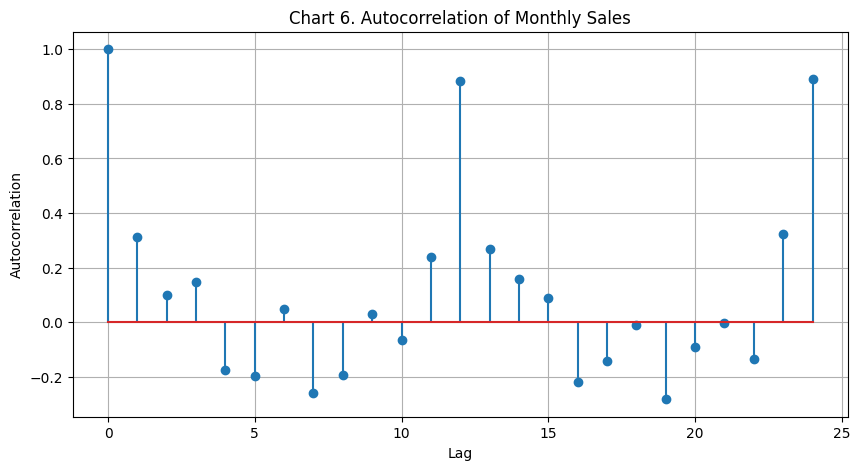

In [149]:
# Extracting monthly sales data
monthly_sales = ds_sales_modified.resample('ME', on='Order Date')['Sales'].sum()

# Calculate autocorrelation
lags = 24
autocorr = [monthly_sales.autocorr(lag) for lag in range(lags + 1)]



# Plotting autocorrelation
plt.figure(figsize=(10, 5))
plt.stem(range(lags + 1), autocorr)
plt.title('Chart 6. Autocorrelation of Monthly Sales')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


Autocorrelation result confirms the seasonal pattern, and there is a positive spike at lag 12.

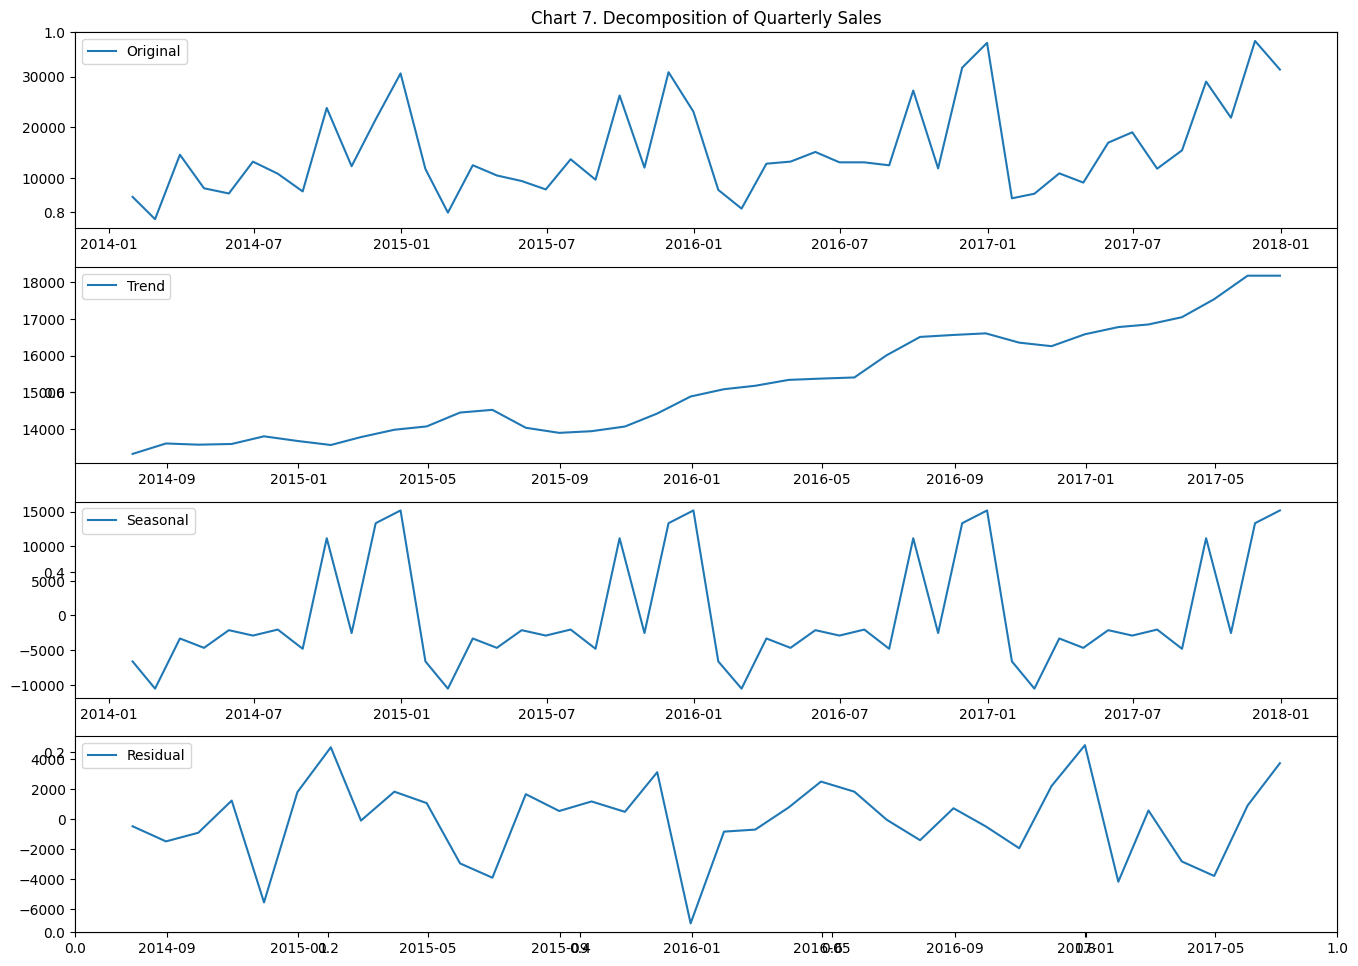

In [150]:

from statsmodels.tsa.seasonal import seasonal_decompose

monthly_sales = ds_sales_modified.set_index('Order Date').resample('ME')['Sales'].sum()

# Decompose the sales data
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(14, 10))
plt.title('Chart 7. Decomposition of Quarterly Sales')

plt.subplot(411)
plt.plot(monthly_sales, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

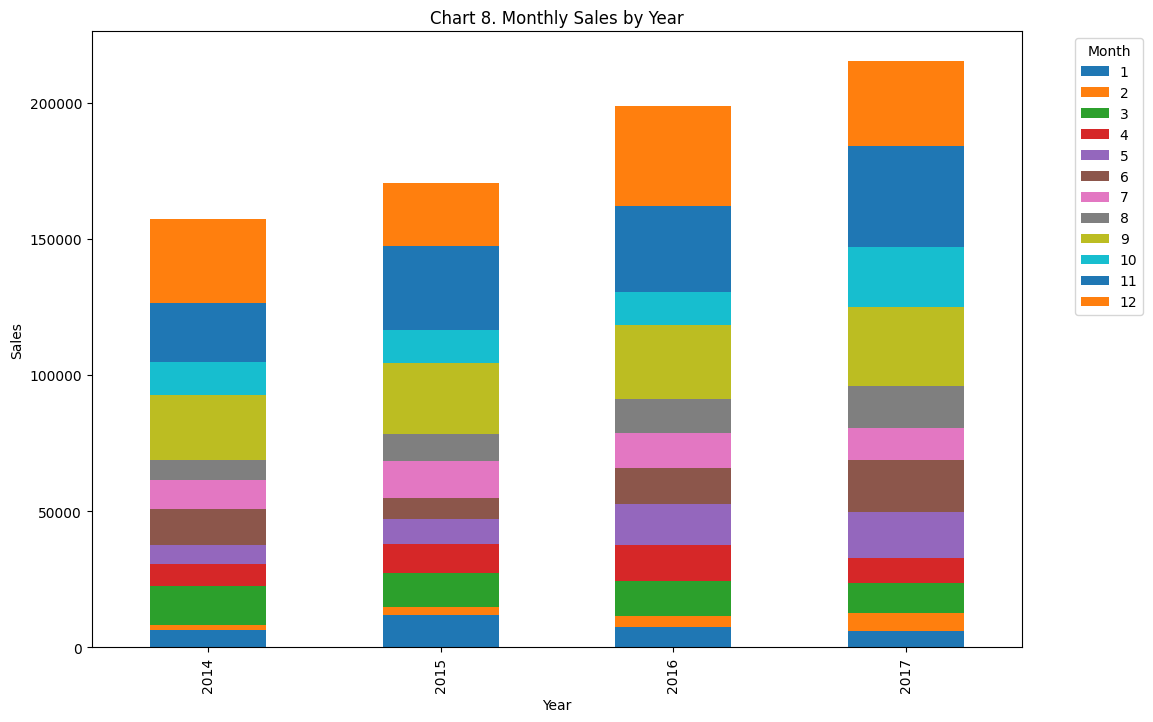

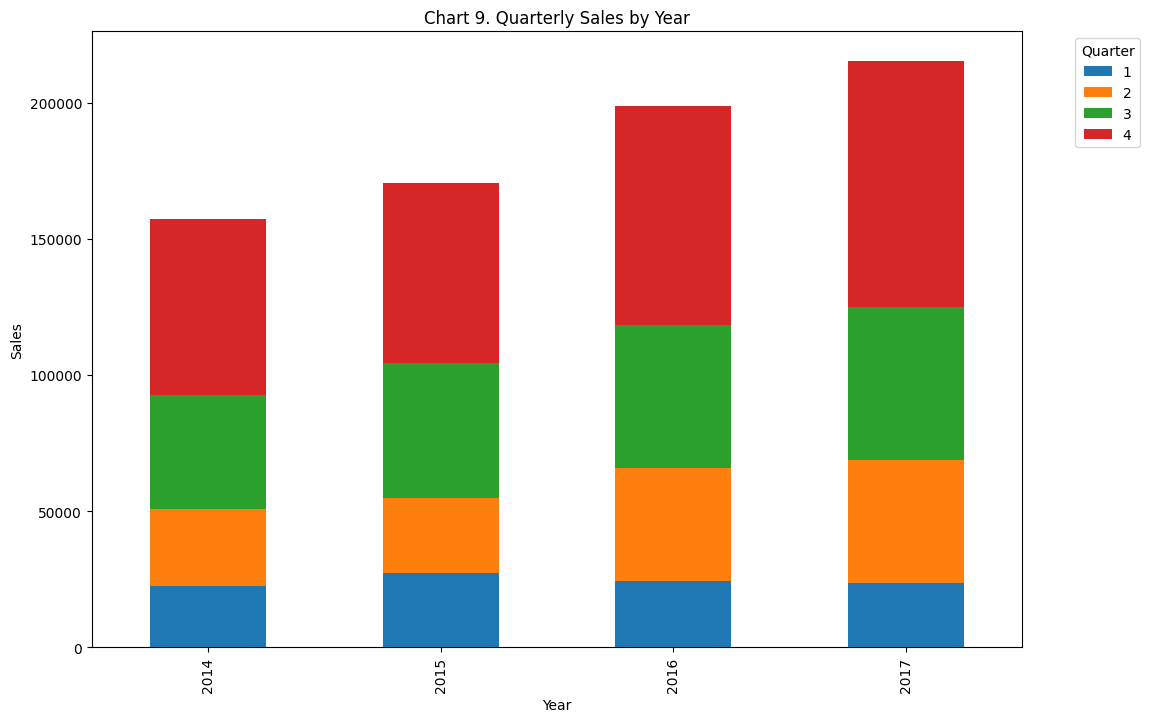

In [151]:
# Aggregate sales by month and year
monthly_sales = ds_sales_modified.groupby(['Year', 'Month'])['Sales'].sum().unstack()

monthly_sales.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Chart 8. Monthly Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Aggregate sales by quarter and year
quarterly_sales = ds_sales_modified.groupby(['Year', 'Quarter'])['Sales'].sum().unstack()

quarterly_sales.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Chart 9. Quarterly Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The time-series plots revealed consistent sales growth, with noticeable peaks and troughs indicating seasonal variations.
Further, we visualized the sales data using stacked bar charts, breaking down sales by month and quarter across different years. These visualizations highlighted the contributions of each month and quarter to the yearly sales, showing that the last quarter of each year consistently had higher sales, possibly due to holiday seasons.

## 5. Identify correlated variables{-}
### 5.1 Feature selection{-}
Based on the visulization results, we are going to drop following features:
- Ship Date: It's related to the order date. We will focus on using the order date.
- Ship Mode: It has no obvious relationship to the sales.
- Customer ID, Row ID, Order ID, Product ID, Product Name, Customer Name: Identifiers that do not contribute to numerical analysis.
- Region: It has no obvious relationship to the sales.
- Segment: It has no obvious relationship to the sales.
- Category: Single category presents in the dataset.
- Country: Single country presents in the dataset.
- Week/Month/Quarter/Year_begin: These columns are for ploting time-seris charts above.
- Profit: This is derived from the sales.

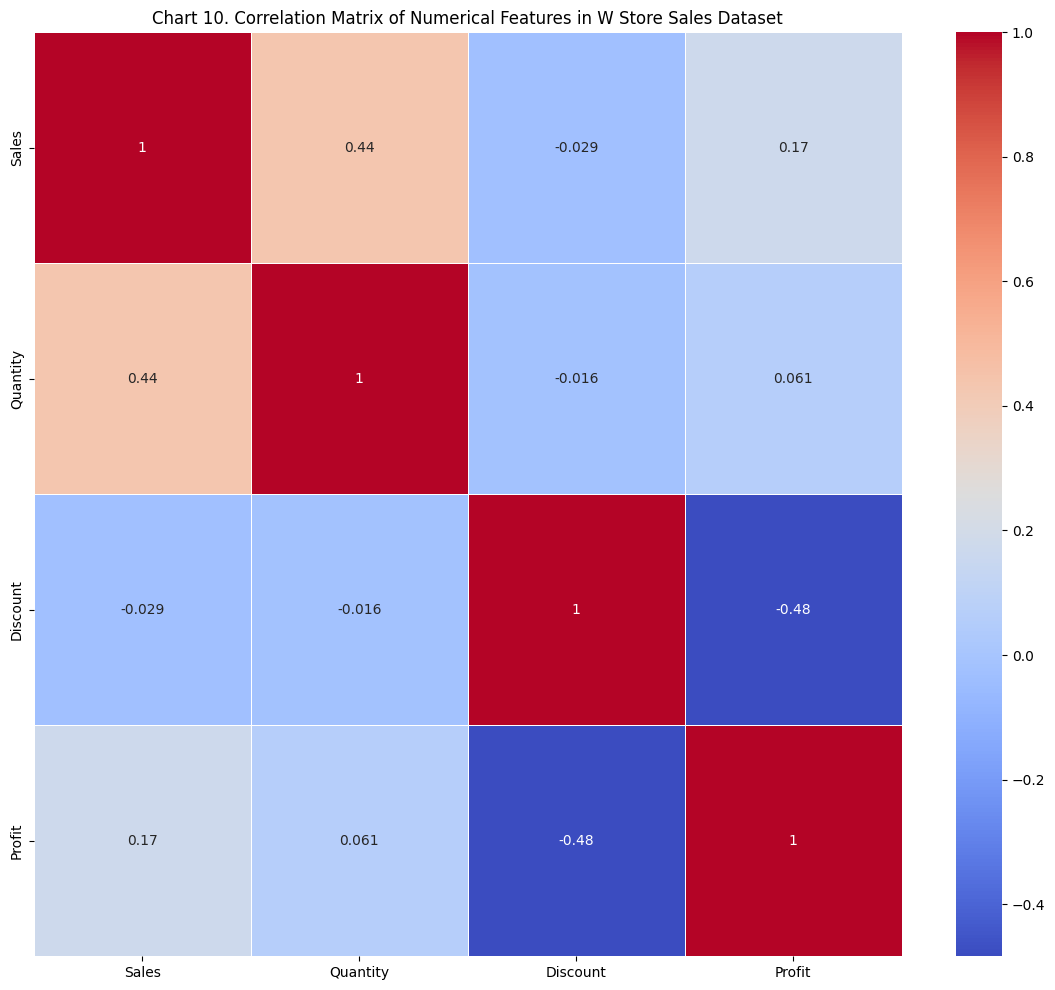

In [152]:
# List of categorical features to be removed
categorical_features = ['Ship Mode', 'Segment', 'City', 'State', 'Region', 'Sub-Category', 'Day of Week', 'Year', 'Month', 'Quarter', 'Week_begin', 'Month_begin', 'Quarter_begin', 'Year_begin', 'Order Date']

# Remove categorical features from the DataFrame
ds_sales_numerical = ds_sales_modified.drop(columns=categorical_features)

# Calculate the correlation matrix for numerical features only
correlation_matrix_numerical = ds_sales_numerical.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_numerical, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Chart 10. Correlation Matrix of Numerical Features in W Store Sales Dataset')
plt.show()

From the correlation heatmap, we observed sales has relative strong relationship with profit and quantity, discount has strong relationship with region, city and profit. We are going to drop the discount column.

From previous analysis, we cound ship mode, segment, region, state (only use city), profit are less helpful for predicting sales, we are going to drop them as well.

In [153]:
ds_sales_selected = ds_sales_modified.drop(columns=['Discount','Ship Mode', 'Segment', 'Region', 'State', 'Profit'])
ds_sales_selected.to_csv('./dataset/store_sales_selected.csv', index=False)
ds_sales_selected.head()


,Order Date,City,Sub-Category,Sales,Quantity,Day of Week,Year,Month,Quarter,Week_begin,Month_begin,Quarter_begin,Year_begin
0,2016-11-08,137,0,261.9600,2,1,2016,11,4,2016-11-07,2016-11-01,2016-10-01,2016-01-01
1,2016-11-08,137,1,731.9400,3,1,2016,11,4,2016-11-07,2016-11-01,2016-10-01,2016-01-01
2,2015-10-11,108,3,957.5775,5,6,2015,10,4,2015-10-05,2015-10-01,2015-10-01,2015-01-01
3,2014-06-09,184,2,48.8600,7,0,2014,6,2,2014-06-09,2014-06-01,2014-04-01,2014-01-01
4,2014-06-09,184,3,1706.1840,9,0,2014,6,2,2014-06-09,2014-06-01,2014-04-01,2014-01-01


## 6. Summary {-}

### Preprocess Steps{-}

1. **Data Loading and Initial Inspection:**
   - Loaded the dataset and displayed the first ten instances to understand the structure and content.
   - Provided key statistical measures like mean and standard deviation.
   - Encoded the categorical features.
   - Visualized numerical columns through histograms to observe the distribution of values.

2. **Data Cleaning:**
   - Checked for missing values and found none.

3. **Visualization:**
   - Used pair plots to spot relationships between numerical features and sales, identifying meaningful relationships with quantity, city, and state.
   - Plotted box charts to further confirm these relationships.
   - Analyzed multi-item transactions but found nothing significant.
   - Created new time-related columns like Day, Week, Month, Quarter, and Year from the Order Date column, revealing a strong seasonal pattern in sales data.

4. **Correlation Analysis:**
   - Dropped irrelevant features and retained useful features based on the analysis results.

Through these steps, key insights into the dataset were gained, identifying important patterns and relationships, and preparing the data for further analysis or modeling.

### Key Findings{-}

- **Irrelevant features:** The following features were deemed not useful for predicting sales: 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Region', 'Segment', 'Product Name', 'Profit', 'Row ID', 'Order ID', 'Country', 'Postal Code', 'Product ID', 'Category'.
- **Sales Patterns:** Most sales are less than $50, with significant variations in sales amounts across different sub-categories.
- **Time Series Patterns:** 
   - Sales increase over the years, showing a clear upward trend.
   - Higher sales on weekends, with Tuesday having the lowest sales. 
   - More sales in September, November, and December, indicating a strong seasonal pattern.

### Next Steps: Predicting Sales by Time and Selected Features{-}



**Preprocess Steps**
1. **Data Loading and Initial Inspection:**
   - Loaded the dataset and displayed the first ten instances to understand the structure and content.
   - Provided key statistical measures like mean and standard deviation.
   - Encoded the categorical features.
   - Visualized numerical columns through histograms observe the distribution of values.

2. **Data Cleaning:**
   - Checked for missing values and found none.

3. **Visualization:**
   - Using pair-plot to spot råelationships between numerical features with sales, found quantity, city and state have meaning relationships.
   - Ploting box charts to further confirm the relaltinship
   - Analyze the multi-item transactions, but nothing speical found.
   - Created new time-related columns like Day, Week, Month, Quarter, and Year from the Order Date column. And found sales data has strong seasonal pattern.

4. **Correlation Analysis**
   - Dropped irrelevant features and kept useful features based on the analysis result above


Through these steps, you gained insights into the dataset, identified key patterns and relationships, and prepared the data for further analysis or modeling.


**Key Findings**
- **Irralevant features:** These features are not useful for predicting sales, 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Region', 'Segment', 'Product Name', 'Profit', 'Row ID', 'Order ID', 'Country', 'Postal Code', 'Product ID', 'Category'.
- **Sales Patterns:** Most sales are less than $50, with significant variations in sales amounts across different sub-categories.
- **Time series patterns:** 
   - sales increase by years, a clear increasing trend
   - more sales on weekend, Tuesday has the lowest sales. And more sales in September, November and December, a strong seasonal pattern



